# toycode로 MDNs 를 이해해 보자 - 2



## 이 노트북에서는 MDNs (Mixture Density Networks) toycode 를 구현해보자 

- 원문링크: http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

## MDN 관련 링크
    
- 비숍: http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf
- 참고장표: http://www.cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.7-MixDensityNetworks.pdf
- 정연우님 구현: https://github.com/maestrojeong/Machine_learning
- 토이코드 구현참고 (나름 쉽게 풀어놓은듯): http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

이전 노트북에서는 하나의 입력에 여러 출력개인걸 MSE로 풀어보려 하니 예측이 엉망이 되어버렸다

    - 이제 MDN - Mixtured Density Networks를 보자
    - 하나의 입력값에 대해 여러 출력값을 예측해준다

### MDN

    MDN은 하나의 입력에 대해 여러 출력이 가능한 경우에 
    여러 출력의 확률적 분포를 예측해보자는 것이다.
    
**예를 들어** 

    x = 1일때 y = 1인 경우가 많고, y = 3 인 경우가 적다면
    확률적으로 1일 경우 90%, 3일 경우 10% 이런식의 예측이 가능하다는 것이다
    
    1) 이때 MDN은 x = 1이 입력될때에 
        - 90%의 확률로 y = 1이라 말하고 
        - 10%의 확률로 y = 3 이라고 말한다.
    
    2) 그리고 이렇게 선택된 y 값에 대한 평균과 분산값을 가지고 
    거기서 랜덤한 값을 가우시안 분포에 따른 확률로 뽑아낸다 
    

MDN은 로봇팔의 위치, 손글씨의 다음 위치등에서 이용할 수 있다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
sess = tf.InteractiveSession()  # https://www.tensorflow.org/versions/r0.10/get_started/basic_usage

### 네트웍의 출력

    - 네트웤은 24 x 3 = 72 개의 값을 출력한다
    - 총 24개의 Mixture(=혼합물)을 출력하는 것이며,
    - 하나의 혼합물은 3개의 값을 가진다 (3개의 값이 바로 pi, mu, stdev가 되는지, 이걸 재료로 만드는지는 좀 더 봐야함)
        1. pi: 전체 혼합물 24개 중에서 해당 혼합물이 선택될 확률이라 보면 되겠다. 따라서 전체 혼합물의 pi들의 합은 1이 된다
        2. mu, stdev: 각각 혼합물들의 가우시안 분포를 그릴 수 있는 평균과 표준편차값이다
        
### 네트웍 모델링
    
    - float32인 x, y 값을 입력으로 받는다
    - Wh, bh, Wo, bo를 거쳐서 최종 output은 [None, NOUT] = [None, 72] 가 된다. 각각의 입력 x 마다 72개의 값이 생성되는 것이다.

In [2]:
##############################################################
# MDN 그래프
##############################################################

NHIDDEN = 24
STDEV = 0.5
KMIX = 24 # number of mixtures. 혼합물(?)의 개수이다. 
NOUT = KMIX * 3 # pi, mu, stdev. 각각의 혼합물은 pi, mu, stdev 성분을 가지고 있다.

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32))

Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
bo = tf.Variable(tf.random_normal([1,NOUT], stddev=STDEV, dtype=tf.float32))

# [None, 1] 과 [1, NHIDDEN] 을 행렬곱했으니 출력은 [None, NHIDDEN]
hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)

# [None, NHIDDEN] 과 [NHIDDEN, NOUT]을 행렬곱했으니 출력은 [None, NOUT]
# 즉 (입력되는 x의 개수, 72) 가 된다
output = tf.matmul(hidden_layer,Wo) + bo

## Mixture Density Parameter

    1. 네트웍이 일단 재료를 만들어서 출력해주면
    2. 이것으로 MDNs 에서 쓸수 있게 만져주는 게 아래의 함수이다
    3. 이 함수의 결과값으로 pdf - propability distribution function을 계산할 수 있다.
    
** 수식과 코드를 자세히 챙겨볼 필요가 있다. **

In [3]:
##############################################################
# probability distribution function을 계산하기 위한 값들을
# 네크웍의 출력인 output에서 연산을 통해 뽑아낸다
##############################################################


def get_mixture_coef(output):

    # 우선 output에서 24개씩 잘라내어 넣을 변수넣을 수 있도록 마련해둔다 KMIX = 24이다
    out_pi = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_sigma = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")
    out_mu = tf.placeholder(dtype=tf.float32, shape=[None,KMIX], name="mixparam")

    # 잘라내서 각각 넣어준다. tf.split() 함수 https://www.tensorflow.org/api_docs/python/tf/split
    out_pi, out_sigma, out_mu = tf.split(output, 3, 1 )  # tf 요즘버전. output을 균등하게 3등분하라 axis = 1


    # exp() 연산결과가 너무 높은값이 나와 연산비용이 들거나 아예 NaN이 뜨는 오류를 예방하는 코드
    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.subtract(out_pi, max_pi)  # 뺄셈. 결국 각각의 값에 대해 최대값을 빼주는 것이다. 
    out_pi = tf.exp(out_pi)


    # https: // www.tensorflow.org / api_docs / python / tf / reciprocal
    normalize_pi = tf.reciprocal(tf.reduce_sum(out_pi, 1, keep_dims=True)) # 24개의 합을 낸 뒤 분수로 만든다 y = 1/x
    out_pi = tf.multiply(normalize_pi, out_pi)  # 각각의 값 / 전체값 = 각각의 확률값

    out_sigma = tf.exp(out_sigma)  # 시그마 = 편차에 exp 먹임

    return out_pi, out_sigma, out_mu  # mu는 그냥 내보낸다

out_pi, out_sigma, out_mu = get_mixture_coef(output)

### 연산의 결과

  **out_pi (확률값)**
    
    - 네크웍을 나온 직후의 raw 값은 각각의 score라고 보면 되겠다.
    
    1. 최대값으로 빼주어서 exp 폭주를 예방한다
    2. exp() 연산을 해준뒤 각각의 값을 전체 값으로 나눠준다 = softmax

  **out_sigma (표준편차)**

    - exp() 연산을 먹여두는데 나중의 연산식에 바로 넣기 위함으로 보인다
  
  **out_mu (평균값)**
  
      - 네크웍이 내보내는 값을 그대로 사용한다
    

### (위 코드 참고) exp() 연산결과가 너무 높아지는 것을 막는 부분이다. 

https://www.tensorflow.org/api_docs/python/tf/reduce_max

    - axis=1 이고 입력 out_pi (shape는 None, 24) 이다.
    - keep_dims=True이므로 해당 rank가 1로 줄어든다
    - 즉 24개중 가장 큰 값을 뽑아내는 것으로 보인다. 결과인 map_pi는 그러면 (None, 1) 이 될것으로 보인다
    
    max_pi = tf.reduce_max(out_pi, 1, keep_dims=True)
    out_pi = tf.subtract(out_pi, max_pi)  # 뺄셈. 결국 각각의 값에 대해 최대값을 빼주는 것이다. 아래 exp 연산 폭주 예방
    out_pi = tf.exp(out_pi)

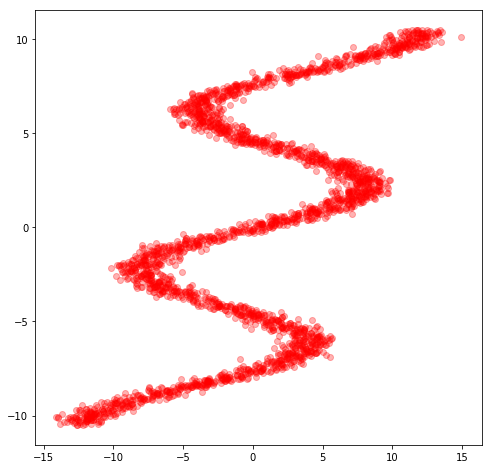

In [4]:
##############################################################
# 아까처럼 x입력에 여러 y값이 있는 train set을 만들어보자
# 샘플을 좀 더 많이 넣음 = 2500개
##############################################################
NSAMPLE = 2500

y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1))) # random noise
x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', alpha=0.3)
plt.show()

### loss function 수식에 대한 이해가 필요하다 

**Probability Density Function**

In [5]:
##############################################################
# 이번에는 l2 loss function을 쓸 수 없다.
# logarithm of the likelihood 를 쓸 것이다.
##############################################################

oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed. 루트 2파이분에 1


def tf_normal(y, mu, sigma):

    result = tf.subtract(y, mu)
    result = tf.multiply(result, tf.reciprocal(sigma))

    result = -tf.square(result)/2

    return tf.multiply(tf.exp(result), tf.reciprocal(sigma)) * oneDivSqrtTwoPI


def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = tf_normal(y, out_mu, out_sigma)  # 1) 여기서 위에 함수를 부른다
    result = tf.multiply(result, out_pi)
    result = tf.reduce_sum(result, 1, keep_dims=True)
    result = -tf.log(result)
    return tf.reduce_mean(result)

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y)
train_op = tf.train.AdamOptimizer().minimize(lossfunc)

In [6]:
##############################################################
# 최적화
##############################################################

sess.run(tf.global_variables_initializer())

NEPOCH = 6000
loss = np.zeros(NEPOCH)  # store the training progress here.

for i in range(NEPOCH):
    #sess.run(train_op,feed_dict={x: x_data, y: y_data})
    #loss[i] = sess.run(lossfunc, feed_dict={x: x_data, y: y_data})
    _, loss[i] = sess.run([train_op, lossfunc], feed_dict={x: x_data, y: y_data})



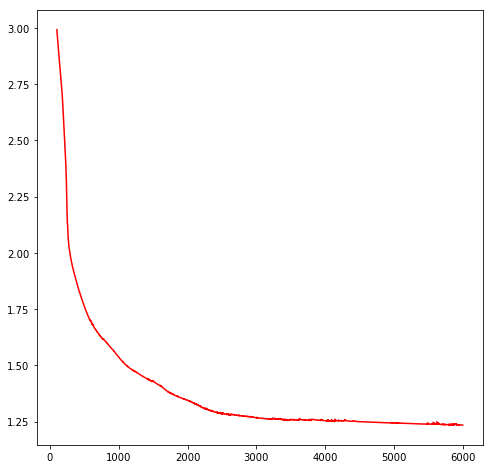

In [7]:
##############################################################
# loss를 그려보자
##############################################################
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [8]:
##############################################################
# 이제 실제 뽑아내는 부분
##############################################################

x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector


def get_pi_idx(x, pdf):
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    print ('error with sampling ensemble')
    return -1


def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
    NTEST = x_test.size
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0
    std = 0
    idx = 0

    # transforms result into random ensembles
    for j in range(0, M):
        for i in range(0, NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result

### get_pi_idx(x, pdf)

    * 결론부터 말하자면 확률에 어느정도 비례해서 index를 고르도록 하는 함수이다.
    
    1. 소스대로라면 x에는 랜덤한 [0, 1] 구간의 값, pdf에는 해당 x에 대한 out_pi 값 (= 24개)가 들어온다
        - out_pi 값은 확률들이니 총합은 1이된다
        
    2. N은 out_pi의 크기이니 24가 된다 
    3. out_pi의 처음값부터 계속 더해서 랜덤한 값인 x보다 크거나 같은 순간의 i = 인덱스값을 리턴하게 하는 것이다. 
    


### generate_ensemble() 

    1. result에 총 입력값 개수 x M(=10)개 만큼의 값을 잡는다
    2. 여기에 [0, 1] 사이의 랜덤값을 넣어준다
    3. rn (result와 같은 shape)에 표준정규분포 랜덤값을 넣어준다
    
    for문을 돌린다
    1. 해당 x (여기서는 i)를 네트웍에 넣었을때 나오는 out_pi 값 24개중 하나의 index를 고른다. get_pi_idx
    2. 해당하는 index의, 네트웤이 출력해낸, 평균값, 표준편차값을 추출해낸다
    3. 추출해낸 정규분포 랜덤값을 result에 저장한다
    
    결과적으로 하나의 입력값에 대하여 총 10개의 임의의 값을 생성하여 리턴한다

x_test.shape,y_test.shape (300, 1) (300, 10)


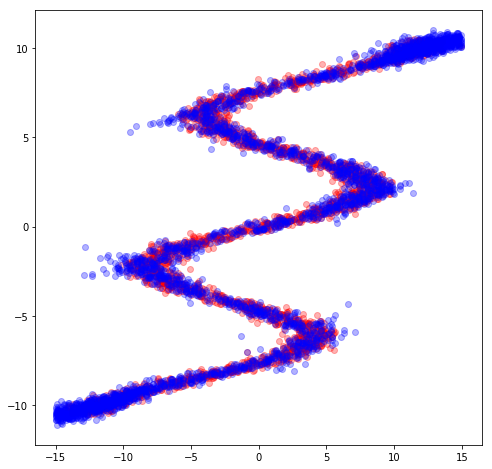

In [9]:
##############################################################
# 생성해내는 값을 보자
##############################################################

out_pi_test, out_sigma_test, out_mu_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)
print('x_test.shape,y_test.shape', x_test.shape,y_test.shape)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()

x_test.shape, out_mu_test.shape (300, 1) (300, 24)


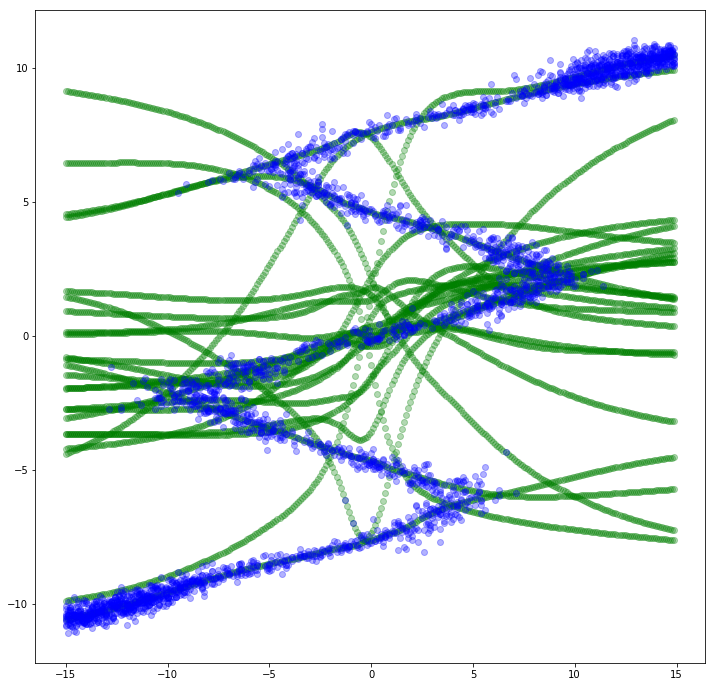

In [10]:
##############################################################
# 우리는 수많은 초록 중에서 원하는 하나를 선택하게 된다
##############################################################

print('x_test.shape, out_mu_test.shape', x_test.shape, out_mu_test.shape)

plt.figure(figsize=(12, 12))
plt.plot(x_test,out_mu_test,'go', x_test,y_test,'bo',alpha=0.3)
plt.show()


### 위 그림 이해하기

1. 녹색은 입력값 x에 대한 out_mu값 24개를 그린 것이다. 
2. 파란색은 그 24개중에 하나를 out_mi 확률에 기대어 골라서 찍은 것이다
    - 정확히는 24개중의 하나를 골라서 그 평균, 표준편차를 따르는 정규분포에서 랜덤값을 고른 것
    - 녹색은 그 정규분포의 딱 평균값만 그린것이다


extent [-15.0, 14.9, -15.0, 14.9]


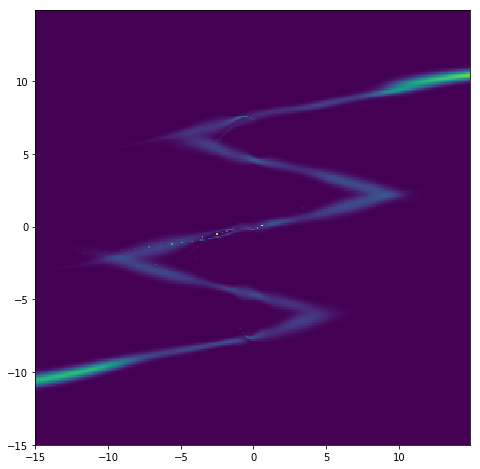

In [11]:
##############################################################
# 마지막으로 히트맵으로 그려보기기
##############################################################

x_heatmap_label = np.float32(np.arange(-15,15,0.1))
y_heatmap_label = np.float32(np.arange(-15,15,0.1))

# 정규분포곡선 수식
def custom_gaussian(x, mu, std):
    x_norm = (x-mu)/std
    result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
    return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
    N = x_heatmap_label.size
    M = y_heatmap_label.size
    K = KMIX

    z = np.zeros((N, M)) # 모든 값을 0으로 만든다

    mu = 0
    std = 0
    pi = 0

    # transforms result into random ensembles
    for k in range(0, K):  
        for i in range(0, M):  
            pi = out_pi[i, k]
            mu = out_mu[i, k]
            std = out_sigma[i, k]
            
            for j in range(0, N):
                z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)
    return z

def draw_heatmap(xedges, yedges, heatmap):
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]  # x_heatmap_label, y_heatmap_lable의 끝에서 끝까지의 값을 의미하는듯
    print("extent", extent)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, extent=extent)
    #plt.imshow(heatmap)
    plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)

### plt.imshow() 에서의 extent 의미 

    - extent : 스칼라값 왼쪽, 오른쪽, 아래, 위 값
    - 어디에 뿌려줄지를 명시하는 것으로 보임
    
    extent : scalars (left, right, bottom, top), optional, default: None

    The location, in data-coordinates, of the lower-left and upper-right corners. 
    If None, the image is positioned such that the pixel centers fall on zero-based (row, column) indices.
    
### z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

    - pi는 입력 x에 대한 24개의 혼합물 각각의 확률값중 특정 혼합물의 확률값
    - custom_gaussian() 함수는 특정 혼합물의 가우시간 분포곡선에서 해당 입력 x의 값
    
    - z[N-j-1, i]는 뭘까? 
        - N은 전체 x 입력값 개수, j는 0부터 N-1까지 증가하는값이므로
        - N-j-1은 맨 오른쪽부터 내려오는 값이겠다. 
        - i는 전체 y입력값들을 하나씩 증가시키는 것
        
    - 이렇게 본다면 for문들은 z를 채워나가는데
        1) 맨 아래쪽의 오른쪽에서 왼쪽으로 채워나가고  
        2) 점점 위로 채워나간다 
        - 각각의 값은 x_heatmap_label 에서의 24개의 혼합물의 값들에 대한 누적값이다
            
        

x_test.shape,y_test.shape (1, 1) (1, 10)


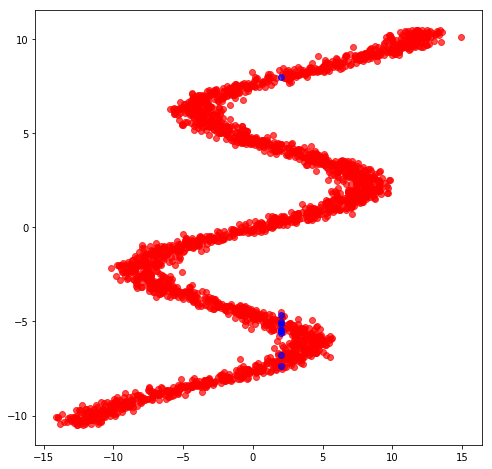

In [14]:
##############################################################
# 딱 하나만 입력해볼까? 
##############################################################

x_test = np.float32(2)
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

out_pi_test, out_sigma_test, out_mu_test = sess.run(get_mixture_coef(output), feed_dict={x: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)
print('x_test.shape,y_test.shape', x_test.shape,y_test.shape)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.7)
plt.show()